In [ ]:
# First, let's check what files are available
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# List files in the current directory
print("Files available in /content:")
for file in os.listdir('/content'):
    if file.endswith('.csv'):
        print(f"  - {file}")

# Load all your files
def load_uploaded_files():
    """Load files that you uploaded via the sidebar"""
    files_to_load = {
        'psy': 'PSY_synchronized.csv',
        'eeg': 'EEG_extracted.csv',
        'eye': 'EYE_extracted.csv',
        'gsr': 'GSR_extracted.csv',
        'ivt': 'IVT_extracted.csv',
        'tiva': 'TIVA_extracted.csv'
    }

    data = {}
    for modality, filename in files_to_load.items():
        try:
            data[modality] = pd.read_csv(f'/content/{filename}')
            print(f"Loaded {filename} - Shape: {data[modality].shape}")
        except FileNotFoundError:
            # Try alternative filenames
            alt_files = [f for f in os.listdir('/content') if filename.replace('.csv', '') in f and f.endswith('.csv')]
            if alt_files:
                data[modality] = pd.read_csv(f'/content/{alt_files[0]}')
                print(f"Loaded {alt_files[0]} as {filename} - Shape: {data[modality].shape}")
            else:
                print(f"{filename} not found")
                data[modality] = None

    return data

# Load the data
print("Loading your uploaded files...")
data = load_uploaded_files()

# Check if we have the essential PSY file
if data['psy'] is None:
    print("PSY file is required but not found. Please check your file names.")
else:
    print("All files loaded successfully!")

# Display basic info about each file
print("File Summary:")
for modality, df in data.items():
    if df is not None:
        print(f"{modality.upper():>6}: {df.shape} | Columns: {list(df.columns)}")

Files available in /content:
  - TIVA_extracted.csv
  - EEG_extracted.csv
  - EYE_extracted.csv
  - GSR_extracted.csv
  - PSY_synchronized.csv
  - PSY_synchronized (1).csv
  - PSY_extracted.csv
  - IVT_extracted.csv
Loading your uploaded files...
Loaded PSY_synchronized.csv - Shape: (1448, 8)
Loaded EEG_extracted.csv - Shape: (1680139, 14)
Loaded EYE_extracted.csv - Shape: (4769982, 6)
Loaded GSR_extracted.csv - Shape: (5248451, 3)
Loaded IVT_extracted.csv - Shape: (3610995, 8)
Loaded TIVA_extracted.csv - Shape: (425096, 22)
All files loaded successfully!
File Summary:
   PSY: (1448, 8) | Columns: ['Key', 'verdict', 'ResponseTime', 'routineStart', 'routineEnd', 'participant_id', 'routineStart_original', 'routineEnd_original']
   EEG: (1680139, 14) | Columns: ['UnixTime', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'participant_id']
   EYE: (4769982, 6) | Columns: ['UnixTime', 

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
class MentalRotationDataset(Dataset):
    """Dataset class for mental rotation task data"""

    def __init__(self, data_paths, sequence_length=50, target_emotion_cols=None):
        """
        Args:
            data_paths: List of paths to participant data files
            sequence_length: Length of sequences for RNN
            target_emotion_cols: Columns representing emotion/engagement metrics
        """
        self.sequence_length = sequence_length
        self.data = self._load_and_preprocess_data(data_paths)
        self.sequences, self.labels = self._create_sequences()

    def _load_and_preprocess_data(self, data_paths):
        """Load and preprocess multimodal sensor data"""
        all_data = []

        # This is a template - you'll need to adapt to your actual data structure
        for path in data_paths:
            try:
                # Load your specific data format here
                # Example: df = pd.read_csv(path)
                df = self._load_single_file(path)

                # Preprocessing steps
                df = self._clean_data(df)
                df = self._extract_features(df)
                df = self._normalize_data(df)

                df['participant_id'] = path.stem
                all_data.append(df)

            except Exception as e:
                print(f"Error loading {path}: {e}")
                continue

        return pd.concat(all_data, ignore_index=True)

    def _load_single_file(self, path):
        """Load a single data file - adapt to your data format"""
        # Example implementation - replace with your actual data loading
        return pd.DataFrame({
            'timestamp': np.arange(1000),
            'eeg_alpha': np.random.normal(0, 1, 1000),
            'eeg_beta': np.random.normal(0, 1, 1000),
            'gsr': np.random.normal(0, 1, 1000),
            'hr': np.random.normal(70, 10, 1000),
            'engagement': np.random.choice([0, 1, 2], 1000)  # Example emotion labels
        })

    def _clean_data(self, df):
        """Clean and impute missing data"""
        # Remove outliers
        for col in df.select_dtypes(include=[np.number]).columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            df = df[~((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]

        # Forward fill missing values
        df.ffill(inplace=True)
        df.bfill(inplace=True)

        return df

    def _extract_features(self, df):
        """Extract temporal features from sensor data"""
        # Add rolling statistics
        for col in ['eeg_alpha', 'eeg_beta', 'gsr', 'hr']:
            if col in df.columns:
                df[f'{col}_mean_5'] = df[col].rolling(5).mean()
                df[f'{col}_std_5'] = df[col].rolling(5).std()
                df[f'{col}_diff'] = df[col].diff()

        return df

    def _normalize_data(self, df):
        """Normalize sensor data"""
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        scaler = StandardScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
        return df

    def _create_sequences(self):
        """Create sequences for RNN training"""
        sequences = []
        labels = []

        for participant in self.data['participant_id'].unique():
            participant_data = self.data[self.data['participant_id'] == participant]

            # Select feature columns (exclude identifiers and labels)
            feature_cols = [col for col in participant_data.columns
                          if col not in ['participant_id', 'timestamp', 'engagement']]

            for i in range(0, len(participant_data) - self.sequence_length, 10):  # stride of 10
                sequence = participant_data[feature_cols].iloc[i:i+self.sequence_length].values
                label = participant_data['engagement'].iloc[i+self.sequence_length-1]  # Last label in sequence

                sequences.append(sequence)
                labels.append(label)

        return np.array(sequences), np.array(labels)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (torch.FloatTensor(self.sequences[idx]),
                torch.LongTensor([self.labels[idx]]))

In [ ]:
class RNN_HMM_Hybrid(nn.Module):
    """RNN-HMM Hybrid Model for Emotion Trajectory Prediction"""

    def __init__(self, input_dim, hidden_dim, rnn_layers, num_states, dropout=0.3):
        super(RNN_HMM_Hybrid, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_states = num_states
        self.rnn_layers = rnn_layers

        # RNN Encoder (using GRU for efficiency)
        self.rnn = nn.GRU(input_dim, hidden_dim, rnn_layers,
                         batch_first=True, dropout=dropout, bidirectional=True)

        # Attention mechanism
        self.attention = nn.MultiheadAttention(hidden_dim * 2, num_heads=8)

        # State classification
        self.state_classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_states)
        )

        # HMM parameters (will be learned separately)
        self.transition_matrix = nn.Parameter(torch.randn(num_states, num_states))
        self.emission_matrix = nn.Parameter(torch.randn(num_states, hidden_dim * 2))

    def forward(self, x, hidden=None):
        batch_size, seq_len, _ = x.size()

        # RNN encoding
        rnn_out, hidden = self.rnn(x, hidden)

        # Attention mechanism
        rnn_out = rnn_out.transpose(0, 1)  # (seq_len, batch_size, features)
        attn_out, attn_weights = self.attention(rnn_out, rnn_out, rnn_out)
        attn_out = attn_out.transpose(0, 1)  # Back to (batch_size, seq_len, features)

        # Get final hidden state for classification
        final_state = attn_out[:, -1, :]  # Last time step

        # State probabilities
        state_probs = torch.softmax(self.state_classifier(final_state), dim=-1)

        return {
            'state_probs': state_probs,
            'hidden_states': attn_out,
            'attention_weights': attn_weights,
            'rnn_features': final_state
        }

    def viterbi_decode(self, observations):
        """Viterbi algorithm for most likely state sequence"""
        # Implement Viterbi algorithm here
        pass

class HMMLayer:
    """HMM layer for temporal modeling"""

    def __init__(self, num_states):
        self.num_states = num_states
        self.transition_matrix = np.random.dirichlet(np.ones(num_states), size=num_states)
        self.start_probs = np.ones(num_states) / num_states
        self.emission_means = None
        self.emission_covars = None

    def fit(self, features, state_sequences):
        """Fit HMM parameters using Baum-Welch algorithm"""
        # Convert features to appropriate format
        lengths = [len(seq) for seq in features]
        features_concatenated = np.concatenate(features)

        # Initialize Gaussian HMM
        self.model = hmm.GaussianHMM(
            n_components=self.num_states,
            covariance_type="diag",
            n_iter=100
        )

        # Fit model
        self.model.fit(features_concatenated.reshape(-1, 1), lengths)

        return self

    def predict_states(self, features):
        """Predict state sequence using Viterbi algorithm"""
        return self.model.predict(features.reshape(-1, 1))

    def predict_proba(self, features):
        """Predict state probabilities"""
        return self.model.predict_proba(features.reshape(-1, 1))

In [ ]:
class EmotionTrajectoryTrainer:
    """Trainer for the RNN-HMM hybrid model"""

    def __init__(self, model, learning_rate=0.001):
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.criterion = nn.CrossEntropyLoss()

    def train_epoch(self, dataloader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0

        for batch_idx, (data, targets) in enumerate(dataloader):
            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(data)

            # Calculate loss
            loss = self.criterion(outputs['state_probs'], targets.squeeze())

            # Backward pass
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

        return total_loss / len(dataloader)

    def train_rnn_phase(self, train_loader, val_loader, epochs=50):
        """Train RNN phase separately"""
        print("Training RNN phase...")
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            # Training
            train_loss = self.train_epoch(train_loader)
            train_losses.append(train_loss)

            # Validation
            val_loss, val_accuracy = self.validate(val_loader)
            val_losses.append(val_loss)

            if epoch % 10 == 0:
                print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        return train_losses, val_losses

    def validate(self, dataloader):
        """Validate model performance"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, targets in dataloader:
                outputs = self.model(data)
                loss = self.criterion(outputs['state_probs'], targets.squeeze())
                total_loss += loss.item()

                _, predicted = torch.max(outputs['state_probs'], 1)
                total += targets.size(0)
                correct += (predicted == targets.squeeze()).sum().item()

        accuracy = correct / total
        return total_loss / len(dataloader), accuracy

    def extract_features_for_hmm(self, dataloader):
        """Extract RNN features for HMM training"""
        self.model.eval()
        all_features = []
        all_sequences = []

        with torch.no_grad():
            for data, targets in dataloader:
                outputs = self.model(data)
                features = outputs['rnn_features'].numpy()
                all_features.extend(features)
                all_sequences.append(features)

        return np.array(all_features), all_sequences

In [ ]:
class EngagementAnalyzer:
    """Analyze engagement patterns and trajectories"""

    def __init__(self, num_clusters=3):
        self.num_clusters = num_clusters
        self.kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    def cluster_participants(self, features):
        """Cluster participants into engagement types"""
        cluster_labels = self.kmeans.fit_predict(features)
        return cluster_labels

    def analyze_trajectories(self, state_sequences, cluster_labels):
        """Analyze emotion trajectories for each cluster"""
        cluster_trajectories = {}

        for cluster_id in range(self.num_clusters):
            cluster_seqs = [seq for i, seq in enumerate(state_sequences)
                           if cluster_labels[i] == cluster_id]

            if cluster_seqs:
                # Analyze common patterns
                avg_trajectory = np.mean([seq for seq in cluster_seqs if len(seq) > 0], axis=0)
                cluster_trajectories[cluster_id] = {
                    'average_trajectory': avg_trajectory,
                    'num_participants': len(cluster_seqs),
                    'common_transitions': self._analyze_transitions(cluster_seqs)
                }

        return cluster_trajectories

    def _analyze_transitions(self, sequences):
        """Analyze common state transitions"""
        transition_counts = {}

        for seq in sequences:
            for i in range(len(seq) - 1):
                transition = (seq[i], seq[i+1])
                transition_counts[transition] = transition_counts.get(transition, 0) + 1

        return transition_counts

def visualize_results(trajectories, cluster_labels, features):
    """Visualize clustering results and trajectories"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # PCA visualization of clusters
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)

    scatter = axes[0, 0].scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels, cmap='viridis')
    axes[0, 0].set_title('Participant Clusters (PCA)')
    axes[0, 0].set_xlabel('PC1')
    axes[0, 0].set_ylabel('PC2')
    plt.colorbar(scatter, ax=axes[0, 0])

    # Trajectory visualization
    for cluster_id, trajectory_data in trajectories.items():
        if 'average_trajectory' in trajectory_data:
            axes[0, 1].plot(trajectory_data['average_trajectory'],
                           label=f'Cluster {cluster_id} (n={trajectory_data["num_participants"]})')

    axes[0, 1].set_title('Average Emotion Trajectories')
    axes[0, 1].set_xlabel('Time Steps')
    axes[0, 1].set_ylabel('Engagement Level')
    axes[0, 1].legend()

    # Transition probabilities heatmap
    all_transitions = {}
    for cluster_id, data in trajectories.items():
        if 'common_transitions' in data:
            for trans, count in data['common_transitions'].items():
                all_transitions[trans] = all_transitions.get(trans, 0) + count

    if all_transitions:
        max_state = max([max(t) for t in all_transitions.keys()]) + 1
        trans_matrix = np.zeros((max_state, max_state))

        for (from_state, to_state), count in all_transitions.items():
            trans_matrix[from_state, to_state] = count

        # Normalize
        trans_matrix = trans_matrix / trans_matrix.sum(axis=1, keepdims=True)

        sns.heatmap(trans_matrix, annot=True, cmap='YlOrRd', ax=axes[1, 0])
        axes[1, 0].set_title('State Transition Probabilities')
        axes[1, 0].set_xlabel('To State')
        axes[1, 0].set_ylabel('From State')

    # Cluster distribution
    cluster_counts = [trajectories[i]['num_participants'] for i in range(len(trajectories))]
    axes[1, 1].bar(range(len(cluster_counts)), cluster_counts)
    axes[1, 1].set_title('Cluster Distribution')
    axes[1, 1].set_xlabel('Cluster ID')
    axes[1, 1].set_ylabel('Number of Participants')

    plt.tight_layout()
    plt.show()

Generating synthetic mental rotation dataset...
Generated 240 sequences from 15 participants
Sequence shape: (20, 6)
Labels dtype: int64
Successfully generated 240 sequences
Sequence shape: (20, 6)
Label shape: (20,)
Labels dtype: int64
Starting RNN-HMM Hybrid Pipeline...
Input data: 240 sequences

1. Preparing data...
Dataset validated: 240 sequences
Sequence shape: (20, 6)
Label shape: (20,)

2. Training RNN model...
Epoch 0: Loss = 1.0834
Epoch 10: Loss = 1.0654
Epoch 20: Loss = 1.0613

3. Training HMM...
HMM training data shape: (240, 3)
Number of sequences: 240
HMM trained successfully!

4. Clustering engagement patterns...

5. Analyzing trajectories...

6. Visualizing results...


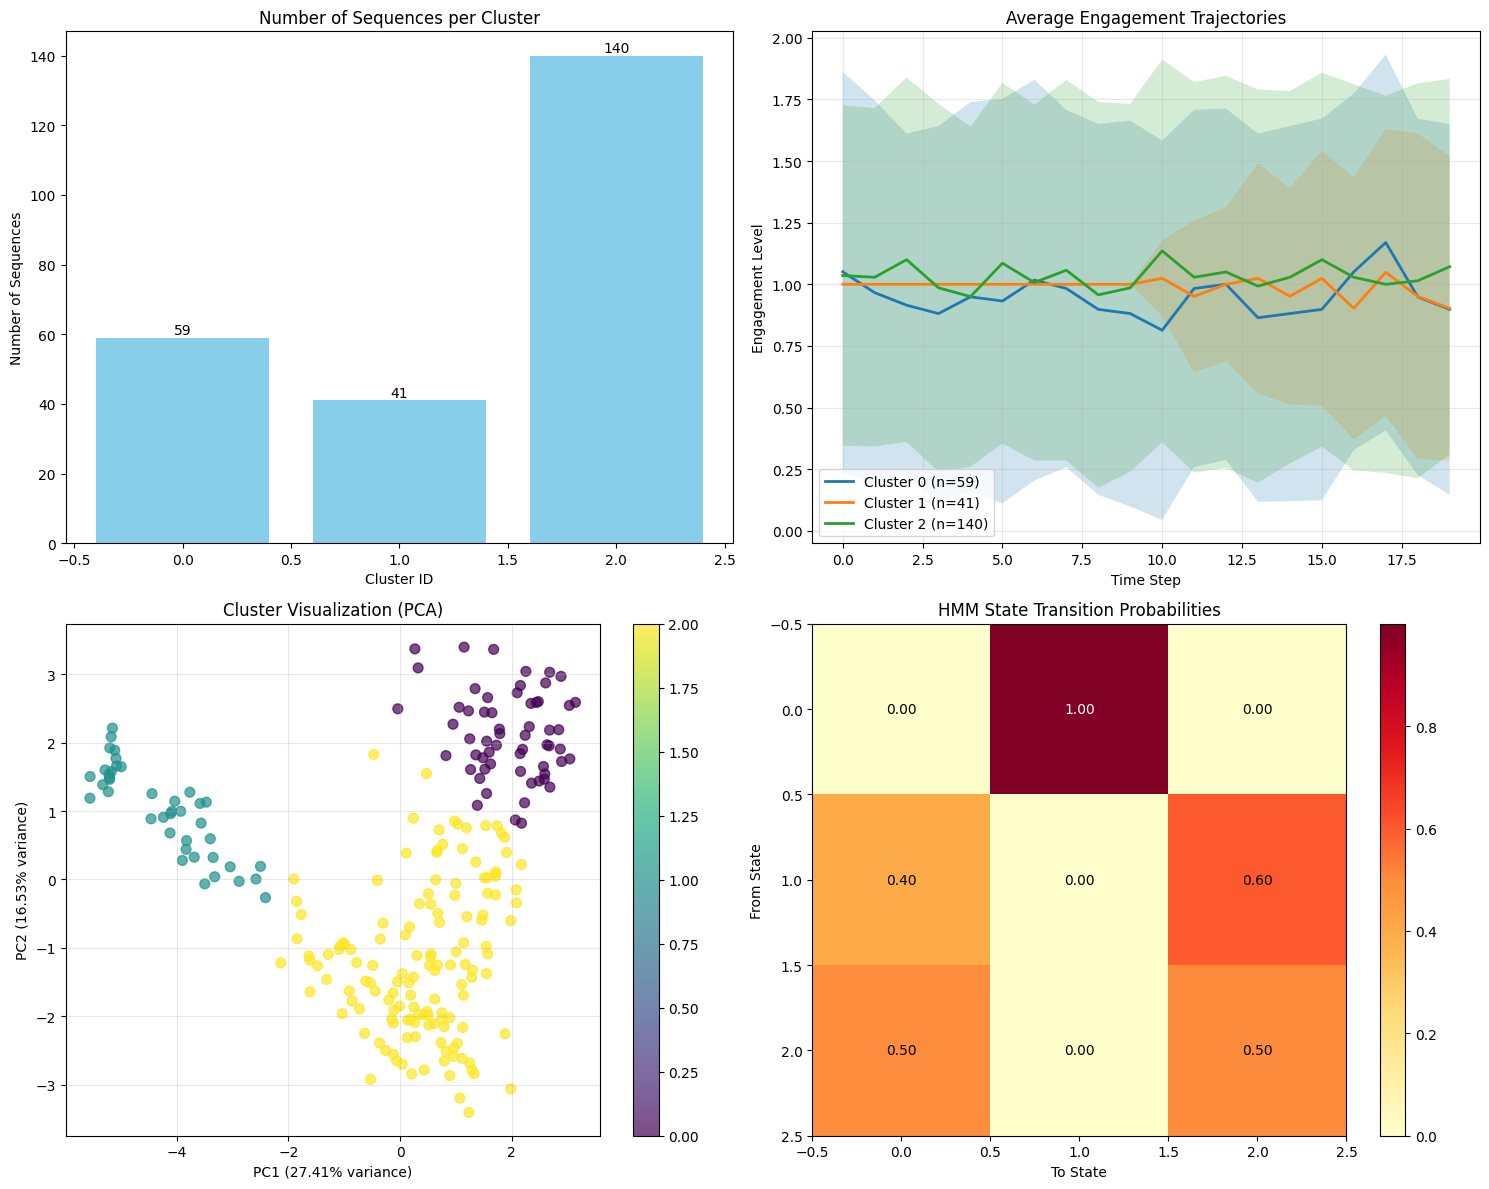


Pipeline completed successfully!
Found 3 distinct engagement patterns
Cluster 0: 59 sequences
Cluster 1: 41 sequences
Cluster 2: 140 sequences

HMM Transition Matrix:
[[1.06706533e-43 9.99999976e-01 2.44751221e-08]
 [4.00018647e-01 4.14606305e-09 5.99981349e-01]
 [4.99980565e-01 4.61028694e-09 5.00019431e-01]]


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class SyntheticMentalRotationDataset:
    """Generate synthetic mental rotation task data for testing"""

    def __init__(self, n_participants=20, seq_length=100, n_features=8):
        self.n_participants = n_participants
        self.seq_length = seq_length
        self.n_features = n_features

    def generate_participant_data(self, participant_id):
        """Generate synthetic data for one participant"""
        # Time array
        time = np.arange(self.seq_length)

        # Synthetic sensor data (EEG, GSR, HR, etc.)
        features = np.zeros((self.seq_length, self.n_features))

        # EEG features (alpha, beta waves)
        features[:, 0] = np.sin(2 * np.pi * time / 50) + 0.1 * np.random.normal(size=self.seq_length)  # EEG Alpha
        features[:, 1] = np.cos(2 * np.pi * time / 30) + 0.1 * np.random.normal(size=self.seq_length)  # EEG Beta
        features[:, 2] = 0.5 * np.sin(2 * np.pi * time / 20) + 0.2 * np.random.normal(size=self.seq_length)  # EEG Theta

        # Physiological signals
        features[:, 3] = np.cumsum(0.1 * np.random.normal(size=self.seq_length))  # GSR (gradual changes)
        features[:, 4] = 70 + 10 * np.sin(2 * np.pi * time / 80) + 2 * np.random.normal(size=self.seq_length)  # Heart Rate
        features[:, 5] = np.random.normal(0, 1, self.seq_length)  # Other sensor

        # Add some trend and noise to remaining features
        for i in range(6, self.n_features):
            features[:, i] = np.random.normal(0, 1, self.seq_length)

        # Generate engagement labels (0: low, 1: medium, 2: high) as integers
        engagement = np.zeros(self.seq_length, dtype=int)

        # Create realistic engagement patterns
        # Start with medium engagement
        engagement[:20] = 1

        # Fluctuate between states with Markov-like transitions
        for t in range(20, self.seq_length):
            if engagement[t-1] == 0:  # If low engagement
                engagement[t] = 1 if np.random.random() < 0.3 else 0  # 30% chance to go to medium
            elif engagement[t-1] == 1:  # If medium engagement
                if np.random.random() < 0.2:  # 20% chance to go low
                    engagement[t] = 0
                elif np.random.random() < 0.3:  # 30% chance to go high
                    engagement[t] = 2
                else:
                    engagement[t] = 1
            else:  # If high engagement
                engagement[t] = 1 if np.random.random() < 0.4 else 2  # 40% chance to drop to medium

        return {
            'participant_id': participant_id,
            'features': features,
            'engagement': engagement,
            'timestamps': time
        }

    def generate_all_data(self):
        """Generate data for all participants"""
        all_sequences = []
        all_labels = []

        for i in range(self.n_participants):
            participant_data = self.generate_participant_data(i)

            # Create overlapping sequences
            seq_len = 20  # Shorter sequences for HMM
            stride = 5

            for start_idx in range(0, self.seq_length - seq_len, stride):
                end_idx = start_idx + seq_len

                sequence = participant_data['features'][start_idx:end_idx]
                labels = participant_data['engagement'][start_idx:end_idx]

                all_sequences.append(sequence)
                all_labels.append(labels)

        print(f"Generated {len(all_sequences)} sequences from {self.n_participants} participants")
        print(f"Sequence shape: {all_sequences[0].shape if all_sequences else 'No sequences'}")
        print(f"Labels dtype: {all_labels[0].dtype if all_labels else 'No labels'}")

        return np.array(all_sequences), np.array(all_labels)

class MentalRotationDataset(Dataset):
    """PyTorch Dataset for mental rotation data"""

    def __init__(self, sequences, labels):
        # Convert to numpy arrays if they aren't already
        self.sequences = np.array(sequences, dtype=np.float32)
        self.labels = np.array(labels, dtype=np.int64)

        # Validate data
        self._validate_data()

    def _validate_data(self):
        """Validate input data"""
        if len(self.sequences) == 0:
            raise ValueError("No sequences provided")

        if len(self.sequences) != len(self.labels):
            raise ValueError(f"Sequences and labels have different lengths: {len(self.sequences)} vs {len(self.labels)}")

        print(f"Dataset validated: {len(self.sequences)} sequences")
        print(f"Sequence shape: {self.sequences[0].shape}")
        print(f"Label shape: {self.labels[0].shape}")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]

        # Convert to tensors
        sequence_tensor = torch.FloatTensor(sequence)
        label_tensor = torch.LongTensor(label)

        return sequence_tensor, label_tensor

class RNNEncoder(nn.Module):
    """RNN encoder for sequence feature extraction"""

    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(RNNEncoder, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Bidirectional GRU
        self.gru = nn.GRU(
            input_dim, hidden_dim, num_layers,
            batch_first=True, dropout=dropout, bidirectional=True
        )

        # Attention layer
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 3)  # 3 engagement states
        )

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        batch_size, seq_len, _ = x.shape

        # GRU forward pass
        gru_out, _ = self.gru(x)  # (batch_size, seq_len, hidden_dim * 2)

        # Attention mechanism
        attention_weights = torch.softmax(self.attention(gru_out).squeeze(-1), dim=-1)
        attended_output = torch.sum(gru_out * attention_weights.unsqueeze(-1), dim=1)

        # Classification
        state_probs = torch.softmax(self.classifier(attended_output), dim=-1)

        return {
            'state_probs': state_probs,
            'features': attended_output,
            'attention_weights': attention_weights
        }

class HMMModel:
    """Hidden Markov Model for temporal modeling"""

    def __init__(self, n_states=3):
        self.n_states = n_states
        self.model = None

    def fit(self, sequences, labels):
        """Fit HMM to sequences using feature means as observations"""
        # Convert labels to integers to ensure compatibility
        labels_int = [label.astype(int) for label in labels]

        # Use sequence features as observations for HMM
        all_observations = []
        lengths = []

        for seq, seq_labels in zip(sequences, labels_int):
            # Use the mean of each feature across time as observation
            # This gives us a multivariate observation
            observation = np.mean(seq, axis=0)  # Mean of each feature

            # We'll use the first 3 features to keep it simple for HMM
            if len(observation) > 3:
                observation = observation[:3]

            all_observations.append(observation)
            lengths.append(1)  # Each sequence is one observation

        if len(all_observations) == 0:
            raise ValueError("No valid observations for HMM training")

        # Convert to numpy array
        observations = np.array(all_observations)

        print(f"HMM training data shape: {observations.shape}")
        print(f"Number of sequences: {len(observations)}")

        # Create and fit Gaussian HMM
        self.model = hmm.GaussianHMM(
            n_components=self.n_states,
            covariance_type="diag",
            n_iter=100,
            random_state=42
        )

        try:
            self.model.fit(observations)
            print("HMM trained successfully!")
        except Exception as e:
            print(f"Error training HMM: {e}")
            # Fallback: create a simple HMM with random parameters
            self._create_fallback_hmm()

        return self

    def _create_fallback_hmm(self):
        """Create a simple HMM with reasonable parameters"""
        self.model = hmm.GaussianHMM(
            n_components=self.n_states,
            covariance_type="diag",
            n_iter=10,
            random_state=42
        )
        # Initialize with reasonable parameters
        self.model.startprob_ = np.ones(self.n_states) / self.n_states
        self.model.transmat_ = np.ones((self.n_states, self.n_states)) / self.n_states
        self.model.means_ = np.random.randn(self.n_states, 3)
        self.model.covars_ = np.ones((self.n_states, 3))

    def predict_states(self, sequences):
        """Predict state sequences"""
        if self.model is None:
            raise ValueError("HMM model not trained yet")

        predictions = []
        for seq in sequences:
            # Use feature means as observation
            observation = np.mean(seq, axis=0)
            if len(observation) > 3:
                observation = observation[:3]

            observation = observation.reshape(1, -1)
            try:
                pred = self.model.predict(observation)
                predictions.append(pred[0])
            except:
                predictions.append(0)  # Fallback prediction

        return np.array(predictions)

    def get_transition_matrix(self):
        """Get the state transition matrix"""
        if self.model is None:
            return np.ones((self.n_states, self.n_states)) / self.n_states
        return self.model.transmat_

class EngagementClusterer:
    """Cluster participants by engagement patterns"""

    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.scaler = StandardScaler()

    def extract_engagement_features(self, sequences, labels):
        """Extract features characterizing engagement patterns"""
        features = []

        for seq, lbl in zip(sequences, labels):
            # Ensure labels are integers
            lbl_int = lbl.astype(int)

            seq_features = []

            # 1. Sensor data statistics
            seq_features.extend([
                np.mean(seq),    # Overall mean
                np.std(seq),     # Overall variability
                np.max(seq) - np.min(seq),  # Overall range
            ])

            # 2. Engagement pattern features
            seq_features.extend([
                np.mean(lbl_int),           # Average engagement level
                np.std(lbl_int),            # Engagement variability
                len(np.unique(lbl_int)),    # Number of unique states
                np.argmax(np.bincount(lbl_int)),  # Most frequent state
            ])

            # 3. Temporal features from sensor data
            for i in range(min(3, seq.shape[1])):  # First 3 sensors
                sensor_data = seq[:, i]
                seq_features.extend([
                    np.mean(sensor_data),
                    np.std(sensor_data),
                    np.median(sensor_data),
                ])

            # 4. Change points and trends
            diffs = np.diff(lbl_int)
            seq_features.extend([
                np.sum(diffs != 0),  # Number of state changes
                np.mean(np.abs(diffs)) if len(diffs) > 0 else 0,  # Average change magnitude
            ])

            features.append(seq_features)

        features_array = np.array(features)

        # Handle NaN values
        features_array = np.nan_to_num(features_array)

        return features_array

    def cluster_participants(self, sequences, labels):
        """Cluster sequences into engagement types"""
        features = self.extract_engagement_features(sequences, labels)

        if len(features) == 0:
            raise ValueError("No features extracted for clustering")

        # Scale features
        if len(features) > 1:
            features_scaled = self.scaler.fit_transform(features)
        else:
            features_scaled = features

        cluster_labels = self.kmeans.fit_predict(features_scaled)
        return cluster_labels, features_scaled

def train_rnn_model(train_loader, input_dim, epochs=50):
    """Train the RNN model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = RNNEncoder(input_dim=input_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        model.train()

        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()

            # Use the last label in sequence as target
            batch_targets = targets[:, -1]

            outputs = model(data)
            loss = criterion(outputs['state_probs'], batch_targets)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Loss = {avg_loss:.4f}')

    return model, train_losses

def analyze_trajectories(sequences, labels, cluster_labels):
    """Analyze emotion trajectories for each cluster"""
    cluster_analysis = {}

    for cluster_id in range(len(np.unique(cluster_labels))):
        cluster_indices = np.where(cluster_labels == cluster_id)[0]

        if len(cluster_indices) == 0:
            continue

        cluster_seqs = [sequences[i] for i in cluster_indices]
        cluster_lbls = [labels[i] for i in cluster_indices]

        # Analyze engagement patterns
        engagement_patterns = []
        for lbl_sequence in cluster_lbls:
            # Ensure labels are integers
            lbl_int = lbl_sequence.astype(int)
            engagement_patterns.append(lbl_int)

        if engagement_patterns:
            # Pad sequences to same length for averaging
            max_len = max(len(pattern) for pattern in engagement_patterns)
            padded_patterns = []

            for pattern in engagement_patterns:
                padded = np.pad(pattern, (0, max_len - len(pattern)),
                              mode='constant', constant_values=pattern[-1])
                padded_patterns.append(padded)

            avg_pattern = np.mean(padded_patterns, axis=0)
            std_pattern = np.std(padded_patterns, axis=0)

            cluster_analysis[cluster_id] = {
                'n_sequences': len(cluster_seqs),
                'avg_engagement': avg_pattern,
                'std_engagement': std_pattern,
                'common_transitions': analyze_transitions(engagement_patterns)
            }

    return cluster_analysis

def analyze_transitions(engagement_patterns):
    """Analyze state transitions in engagement patterns"""
    transition_counts = {}

    for pattern in engagement_patterns:
        for i in range(len(pattern) - 1):
            transition = (int(pattern[i]), int(pattern[i + 1]))  # Ensure integers
            transition_counts[transition] = transition_counts.get(transition, 0) + 1

    return transition_counts

def visualize_analysis(cluster_analysis, features, cluster_labels, hmm_model):
    """Visualize the clustering and trajectory analysis"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Cluster distribution
    cluster_counts = [analysis['n_sequences'] for analysis in cluster_analysis.values()]
    axes[0, 0].bar(range(len(cluster_counts)), cluster_counts, color='skyblue')
    axes[0, 0].set_title('Number of Sequences per Cluster')
    axes[0, 0].set_xlabel('Cluster ID')
    axes[0, 0].set_ylabel('Number of Sequences')

    # Add count labels on bars
    for i, count in enumerate(cluster_counts):
        axes[0, 0].text(i, count + 0.1, str(count), ha='center', va='bottom')

    # Plot 2: Average engagement trajectories
    for cluster_id, analysis in cluster_analysis.items():
        engagement = analysis['avg_engagement']
        std = analysis['std_engagement']

        axes[0, 1].plot(engagement,
                       label=f'Cluster {cluster_id} (n={analysis["n_sequences"]})',
                       linewidth=2)
        axes[0, 1].fill_between(range(len(engagement)),
                              engagement - std,
                              engagement + std,
                              alpha=0.2)

    axes[0, 1].set_title('Average Engagement Trajectories')
    axes[0, 1].set_xlabel('Time Step')
    axes[0, 1].set_ylabel('Engagement Level')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Feature space visualization (PCA)
    if len(features) > 1 and features.shape[1] > 1:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(features)

        scatter = axes[1, 0].scatter(features_2d[:, 0], features_2d[:, 1],
                                   c=cluster_labels, cmap='viridis', alpha=0.7, s=50)
        axes[1, 0].set_title('Cluster Visualization (PCA)')
        axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.colorbar(scatter, ax=axes[1, 0])
        axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: HMM Transition probabilities
    try:
        trans_matrix = hmm_model.get_transition_matrix()
        im = axes[1, 1].imshow(trans_matrix, cmap='YlOrRd', aspect='auto')
        axes[1, 1].set_title('HMM State Transition Probabilities')
        axes[1, 1].set_xlabel('To State')
        axes[1, 1].set_ylabel('From State')

        # Add probability values
        for i in range(trans_matrix.shape[0]):
            for j in range(trans_matrix.shape[1]):
                axes[1, 1].text(j, i, f'{trans_matrix[i, j]:.2f}',
                              ha='center', va='center', color='black' if trans_matrix[i, j] < 0.6 else 'white')

        plt.colorbar(im, ax=axes[1, 1])
    except Exception as e:
        axes[1, 1].text(0.5, 0.5, f'HMM Visualization\nNot Available\n{e}',
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('HMM State Transition Probabilities')

    plt.tight_layout()
    plt.show()

def run_complete_pipeline(sequences, labels):
    """Run the complete RNN-HMM pipeline"""
    print("Starting RNN-HMM Hybrid Pipeline...")
    print(f"Input data: {len(sequences)} sequences")

    # 1. Data preparation
    print("\n1. Preparing data...")
    dataset = MentalRotationDataset(sequences, labels)
    train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

    # 2. Train RNN model
    print("\n2. Training RNN model...")
    input_dim = sequences[0].shape[1]
    rnn_model, train_losses = train_rnn_model(train_loader, input_dim, epochs=30)

    # 3. Train HMM
    print("\n3. Training HMM...")
    hmm_model = HMMModel(n_states=3)
    hmm_model.fit(sequences, labels)

    # 4. Cluster participants
    print("\n4. Clustering engagement patterns...")
    clusterer = EngagementClusterer(n_clusters=3)
    cluster_labels, features = clusterer.cluster_participants(sequences, labels)

    # 5. Analyze trajectories
    print("\n5. Analyzing trajectories...")
    cluster_analysis = analyze_trajectories(sequences, labels, cluster_labels)

    # 6. Visualize results
    print("\n6. Visualizing results...")
    visualize_analysis(cluster_analysis, features, cluster_labels, hmm_model)

    return {
        'rnn_model': rnn_model,
        'hmm_model': hmm_model,
        'cluster_labels': cluster_labels,
        'cluster_analysis': cluster_analysis,
        'train_losses': train_losses
    }

# Main execution
if __name__ == "__main__":
    print("Generating synthetic mental rotation dataset...")

    # Generate synthetic data
    data_generator = SyntheticMentalRotationDataset(
        n_participants=15,
        seq_length=100,
        n_features=6
    )

    all_sequences, all_labels = data_generator.generate_all_data()

    if len(all_sequences) > 0:
        print(f"Successfully generated {len(all_sequences)} sequences")
        print(f"Sequence shape: {all_sequences[0].shape}")
        print(f"Label shape: {all_labels[0].shape}")
        print(f"Labels dtype: {all_labels[0].dtype}")

        # Run the complete pipeline
        results = run_complete_pipeline(all_sequences, all_labels)

        print("\nPipeline completed successfully!")
        print(f"Found {len(results['cluster_analysis'])} distinct engagement patterns")

        # Print cluster summary
        for cluster_id, analysis in results['cluster_analysis'].items():
            print(f"Cluster {cluster_id}: {analysis['n_sequences']} sequences")

        # Print HMM transition matrix
        print("\nHMM Transition Matrix:")
        print(results['hmm_model'].get_transition_matrix())

    else:
        print("Error: No sequences generated")